# <center>FAIR PCA</center>
#### <center>Compressed Sensing - ENSAE </center>

<center>Authors : R$\textbf{Y}$m$\textbf{E}$ Kabak & Mehdi Bennaceur </center>

<center> $\textit{This notebook contains the code to go with the report we submitted.}$ 
    
    
    
The goal of our project is to study the concept of Fairness in the framework of PCA. Dimensionality Reduction is widely used by statisticians as preprocessing, both in the academic and professional world, implying that any issue in this step could impact the entire pipeline. In particular the issue discussed here is that of Fairness, which is of increasing interest to many researchers as statistical methods and algorithm have an increasing importance and impact on people nowadays. 

For our work we focus on two papers Samadi et al. (2018) and Uhtaipon et al. (2019), the first one introduces and define a concept for fairness in the context of PCA (**Fair PCA**), the second one introduces a more general framework which includes as particular case the fair PCA problem. This notebook contains the implementation and experiment part of our work and is mainly focused on the first paper as we decided to implement the algorithm it contains.


In this notebook, we briefly recall the standard PCA viewed as a minimization problem and then go on to presenting and implementing it. The report contain technical and mathematical details which are not all reported here.



The original implementation of the Fair PCA algorithm is in matlab, it can be found here : https://github.com/samirasamadi/Fair-PCA - A link to download the data used is also present on the page. 

In [16]:
#starts by importing necessary packages
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os
import scipy.misc as s
import pandas as pd
import random
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from cvxopt import matrix, solvers

## Standard PCA - Minimization of Reconstruction Error

Standard PCA or (Vanilla PCA in our report) consist in finding an optimal rank $d$ appromixation of a dataset. The optimallity is defined as minimization of reconstruction error. 

More formally, let $X = [x_1, \dots, x_n]$ be a set of points such that $x_i \in \mathbb{R}^p$. Applying PCA with target dimension $d < p$ to these points provides a d-dimensional hyperplane for which the average distance of projection is minimized. 

In the following figure, we provide an illustration of this. For ease of visualisation, we consider a simulated dataset $X \in \mathbb{R}^{100 \times 3}$ in which we artificially introduce correlation between the 3 features (so that using PCA makes sense). 

In [40]:
#Creating a simulated dataset X
np.random.seed(5)
X=np.random.randn(100, 3)*5
X[:, 1] = X[:, 0] * 2 + np.random.randn(100) + X[:, 1] #adding correlation
X[:, 2] = X[:, 1] * 0.8 + np.random.randn(100) #same

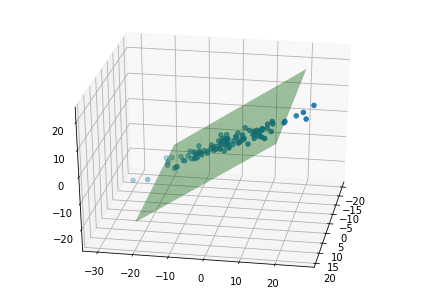

In [14]:
#Fitting Vanilla PCA to X, with d = 2
pca = PCA(n_components=2)
pca.fit(X)
C = pca.components_ #contains the vectors than span the hyperplan on which we will project the data.

#The following is just basic code to plot an hyperplane in 3D
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.view_init(30, 10)
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
#taking 3 random points on the hyperplan
p0 = C[0] * 0.2 + C[1] * 0.15
p1 = C[0] * 0.1 + C[1] * 0.4
p2 = C[0] * 0.3 + C[1] * 0.02

x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

point  = np.array(p0)
normal = np.array(u_cross_v)

d = -point.dot(normal)

xx, yy = np.meshgrid(range(-20,20), range(-20,20))

z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

ax.plot_surface(xx, yy, z, alpha=0.4, color='green')
plt.show()

The blue points are the original data we simulated and they lie in $\mathbb{R}^3$. We used PCA with $d=2$ to obtain an optimal representation of these points in $\mathbb{R}^2$. This is represented by the green hyperplane, this plane is such that the average distance between the points and their orthogonal projection on the plane is minimized. This is exactly minimizing the **reconstruction error** as detailed in the report. The reconstruction error between a matrix and its lower rank approximation is defined as follows. 

Given two matrices $Y$ and $Z$ of same size, the reconstruction error of $Y$ w.r.t $Z$ is defined as $|| Y - Z ||_F^2$. We implemented this below with on slight adjustement which is the division by the number of points : our function returns the average reconstruction error.

In [15]:
def re(a, b):
    return np.linalg.norm(a-b, ord='fro')**2 / a.shape[0]

Before introducing the Fair PCA Framework, let us illustrate the use of PCA on real data. 

# Faces in the Wild Dataset

This is one of the dataset used in Samadi et al. (2018). Credit for the data : 
Gary B. Huang, Manu Ramesh, Tamara Berg, and Erik Learned-Miller. Labeled faces in the wild: A database for studying face recognition in unconstrained environments. Technical Report 07-49, University of Massachusetts, Amherst, October 2007.

In [67]:
sex = pd.read_csv("data/images/sex.txt", header=None).to_dict()[0] # file used to map from index to sex
imgs = os.listdir("data/images/") # reading all file names in the directory to load the images
imgs = [f for f in imgs if 'img' in f] #deleting non image files

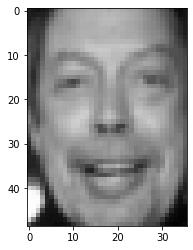

In [68]:
plt.imshow(np.loadtxt("data/images/" + "img0.txt"), cmap='gray') #example image

In [69]:
np.loadtxt("data/images/" + "img1.txt").shape

(49, 36)

In [70]:
shape = (49,36) #shape of an image, number of pixels is then 49*39 = 1784

In [71]:
#Loading all the images into one dataset 
random.shuffle(imgs)
male_faces = pd.DataFrame([])
female_faces = pd.DataFrame([])
t = 0
for f in imgs:
    if t%500 == 0:
        print("Done : ", t)
    t+=1
    if sex[int(f[3:-4])] == 1:#male
        im = np.loadtxt("data/images/" + f)
        male_faces=male_faces.append(pd.Series(im.flatten(), name=f[3:-4]))
    if sex[int(f[3:-4])] == 0:#female
        im = np.loadtxt("data/images/" + f)
        female_faces=female_faces.append(pd.Series(im.flatten(), name=f[3:-4]))

Done :  0
Done :  500
Done :  1000
Done :  1500
Done :  2000
Done :  2500
Done :  3000
Done :  3500
Done :  4000
Done :  4500
Done :  5000
Done :  5500
Done :  6000
Done :  6500
Done :  7000
Done :  7500
Done :  8000
Done :  8500
Done :  9000
Done :  9500
Done :  10000
Done :  10500
Done :  11000
Done :  11500
Done :  12000
Done :  12500
Done :  13000


In [72]:
#Create the dataset of all faces and normalize it
all_faces = pd.concat([male_faces, female_faces], axis=0)
all_faces = all_faces/255
all_faces = all_faces 
all_faces.shape

(13232, 1764)

In [73]:
#Create the subset of male faces and center it, + normalization
A = male_faces.copy()
A = A/255
A = A - np.mean(A, axis=0)
A.shape

(10270, 1764)

In [74]:
#Create the subset of female faces and center it, + normalization
B = female_faces.copy()
B = B/255
B = B - np.mean(B, axis=0)
B.shape

(2962, 1764)

We see that we have 

In [75]:
M = all_faces - np.mean(all_faces, axis=0) #Centering the dataset containing all images

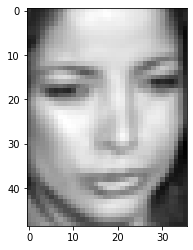

In [76]:
plt.imshow(np.array(female_faces)[0].reshape(shape), cmap='gray') #how to recreate an image from a row of the matrix B

# Credit Data

Here we load and preprocess a second Dataset (easier to use on our own computer because a lot smaller than the previous one). this dataset is also used by Samadi et al. (2018) and contains default credit data. Original Data with credits to authors as well as documentation can be found here : https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. 

In [3]:
credit = pd.read_csv('data_samsam/data/credit/default_degree.csv', header=1)

In [4]:
credit.head()

,ID,EDUCATION,SEX,LIMIT_BAL,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,2,2,20000,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,2,2,2,120000,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,3,2,2,90000,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,4,2,2,50000,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,5,2,1,50000,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [4]:
credit.shape #The data lies in a much smaller space than the images which means everything will run faster

(30000, 24)

In [5]:
credit.drop('ID', axis=1, inplace=True)

In [8]:
credit.EDUCATION.replace([0, 4, 5, 6], 4, inplace=True) #Putting unknown categories under the "Other tag"
credit.EDUCATION.unique()

array([2, 1, 3, 4], dtype=int64)

Highly educated individuals are those for which the variable **EDUCATION** is 0 or 1. The others are classified in low education. In the following few lines we just create are variable to discriminate between the two and the dataset we will use.

In [9]:
credit["EDU_NORM"] = (credit['EDUCATION']-1)*(credit['EDUCATION']-2) 

In [10]:
credit.EDU_NORM.unique()

array([0, 2, 6], dtype=int64)

In [11]:
credit.EDU_NORM.replace([2, 6], 1, inplace=True)

In [13]:
data = credit.drop(['EDUCATION', 'EDU_NORM'], axis=1)

In [14]:
#Scaling the data for PCA
scaler = StandardScaler()
scaler.fit(data)
data_transformed = pd.DataFrame(scaler.transform(data))
data_transformed.columns = data.columns

In [15]:
data_transformed['EDU_NORM'] = credit["EDU_NORM"]
data_transformed.head()

,SEX,LIMIT_BAL,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDU_NORM
0,0.810161,-1.136720,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,0
1,0.810161,-0.365981,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,0
2,0.810161,-0.597202,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0
3,0.810161,-0.905498,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0
4,-1.234323,-0.905498,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0


In [16]:
#Low Educated individuals:
data_low = data_transformed[data_transformed['EDU_NORM']==1]
#High Educated individuals:
data_high = data_transformed[data_transformed['EDU_NORM']==0]

mean_low_edu = data_low.mean()[:-1]
mean_high_edu = data_high.mean()[:-1]

In [17]:
data_low_centred = data_low.iloc[:,:-1]-mean_low_edu
data_high_centred = data_high.iloc[:,:-1]-mean_high_edu

In [18]:
A_credit, B_credit = data_low_centred, data_high_centred

In [19]:
A_credit.shape, B_credit.shape

((5385, 22), (24615, 22))

In [20]:
M_credit = pd.concat([data_low_centred, data_high_centred], axis=0)
M_credit.head()

,SEX,LIMIT_BAL,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
8,0.820071,0.066978,-0.822909,-1.295188,-0.089398,0.001396,1.704881,0.089744,0.152570,0.192488,...,-0.476284,-0.432650,-0.411845,-0.528742,-0.100073,-0.230889,-0.222213,-0.196410,-0.182086,-0.176799
9,-1.224412,-0.857909,1.092943,-0.535784,-1.869102,-1.669216,-1.637232,-1.620946,-0.729911,-0.677101,...,-0.650882,-0.622463,-0.391876,-0.357584,-0.301063,-0.230889,-0.246749,0.570032,-0.174101,-0.233051
10,0.820071,0.529422,1.092943,-0.644270,-0.089398,0.001396,1.704881,0.089744,0.152570,-0.677101,...,-0.571067,-0.583400,-0.575753,-0.528541,-0.161837,-0.230369,-0.243909,-0.241093,-0.002875,-0.229339
15,0.820071,-0.626687,3.008795,-1.837620,0.800453,1.672008,0.033825,0.089744,0.152570,0.192488,...,-0.245449,-0.175235,-0.120083,-0.083896,-0.301063,-0.165787,-0.184273,-0.183643,-0.162450,-0.171174
20,0.820071,-0.010096,1.092943,-0.101838,-0.089398,0.001396,0.033825,0.089744,0.152570,-0.677101,...,-0.297751,-0.301999,-0.411697,-0.575574,-0.119936,-0.164181,-0.189952,-0.132577,-0.186668,1.666239


Now we have loaded all the data we need, we can start focusing on PCA and Fair PCA. To summarize the data we have : 

    - M : dataframe containing all images shape (n_images, 1784)
    - A : dataframe containing all male images shape (n_images_male, 1784)
    - B : dataframe containing all female images shape (n_images_female, 1784)
    - M_credit : dataframe containing all credit data shape (n_ind, 22)
    - A_credit : dataframe containing credit data for low education shape (n_ind_low, 22)
    - B_credit : dataframe containing credit data for high education shape (n_ind_high, 22)
    - Any of theses with the extension "_test" means it's a sample of the data (usually of size 500 here). We did that to be able to run the algortihms on our own computers.

# Standard PCA - Illustration

Here, we illustration how one can use PCA to approximate the image matrix in lower dimension (with lower rank) and reconstruct the images.

In [15]:
%%time
pca = PCA(n_components=20)
pca.fit(M) #fitting PCA with d = 20

Wall time: 5.38 s


PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
projected = pca.inverse_transform(pca.transform(M)) #this gives the rank d (=20) approximation of M 

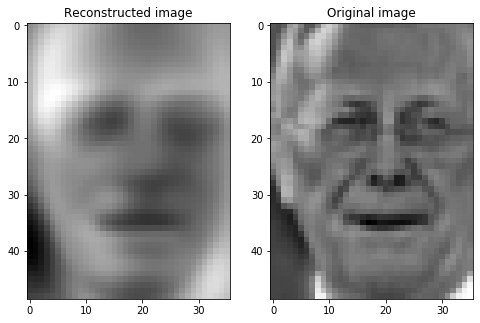

Reconstruction error is :  10.799749950050161


In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(projected[0].reshape(shape), cmap='gray')
axes[0].set_title("Reconstructed image")
axes[1].imshow(np.array(M)[0].reshape(shape), cmap='gray')
axes[1].set_title("Original image")
plt.show()
print("Reconstruction error is : ", np.sum(np.square(np.array(M)[0]-np.array(projected)[0])))

In [19]:
re(M, projected) #Average reconstruction error on the entire dataset

11.414602663131795

Next we reproduce the experiment that motivated Samadi et al. (2018) to look for a Fair PCA. 

### Bias between males and females in PCA 

We run pca on the entire dataset once for each value of d we consider, then we compute the reconstruction error men and women.

In [19]:
%%time
re_male = []
re_female = []
dim = [d for d in range(2,21)]
for d in dim:
    pca = PCA(n_components=d)
    pca.fit(M)
    #computing RE for men with dimensionnality reduction d
    re_male.append(re(A, pca.inverse_transform(pca.transform(A))))
    #computing RE for women with dimensionnality reduction d
    re_female.append(re(B, pca.inverse_transform(pca.transform(B))))

Wall time: 22.1 s


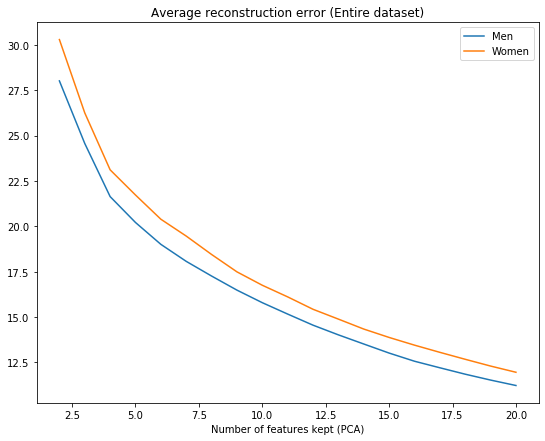

In [20]:
plt.figure(figsize=(9, 7))
plt.plot(dim, re_male, label="Men")
plt.plot(dim, re_female, label="Women")
plt.legend()
plt.title("Average reconstruction error (Entire dataset)")
plt.xlabel("Number of features kept (PCA)")
plt.show()

As reported in the paper we see a difference between men and women that is consistent for every dimension. Below, we plot the relative difference to have it in %.

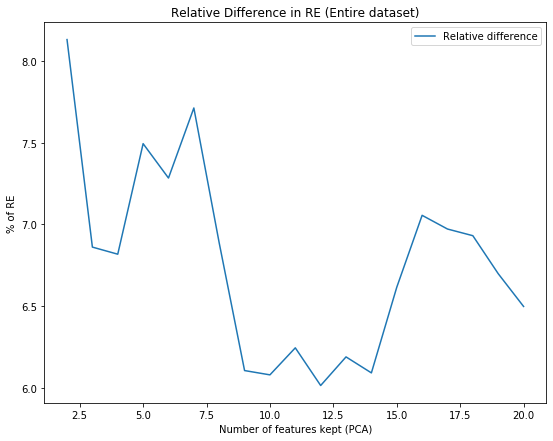

In [21]:
rel_diff = (np.array(re_female)-np.array(re_male))/np.array(re_male)
plt.figure(figsize=(9, 7))
plt.plot(dim, rel_diff*100, label="Relative difference")
plt.legend()
plt.title("Relative Difference in RE (Entire dataset)")
plt.xlabel("Number of features kept (PCA)")
plt.ylabel("% of RE")
plt.show()

The original dataset contains more men than women, therefore as suggested in the paper we sample 500 men and 500 women for the data and repeat the above experiment. We do that 20 times and then report average values obtaines below.

In [22]:
%%time
male_error = {}
female_error = {}
for bt in range(20):
    if bt%5==0:
        print("------------")
        print("Sample number "+str(bt)+" in process...")
    #We re center the sample to ensure 0 mean.
    sample = pd.concat([male_faces.sample(500), female_faces.sample(500)], axis=0)
    sample = sample/255
    sample = sample - np.mean(sample, axis=0)
    re_male = []
    re_female = []
    dim = [d for d in range(2,21)]
    for d in dim:
        pca = PCA(n_components=d)
        pca.fit(sample)
        projected = pca.inverse_transform(pca.transform(sample))
        #computing RE for men with dimensionnality reduction d
        re_male.append(re(sample[:500], projected[:500]))
        #computing RE for women with dimensionnality reduction d
        re_female.append(re(sample[500:], projected[500:]))
    male_error[bt] = re_male
    female_error[bt] = re_female

------------
Sample number 0 in process...
------------
Sample number 5 in process...
------------
Sample number 10 in process...
------------
Sample number 15 in process...
Wall time: 48.4 s


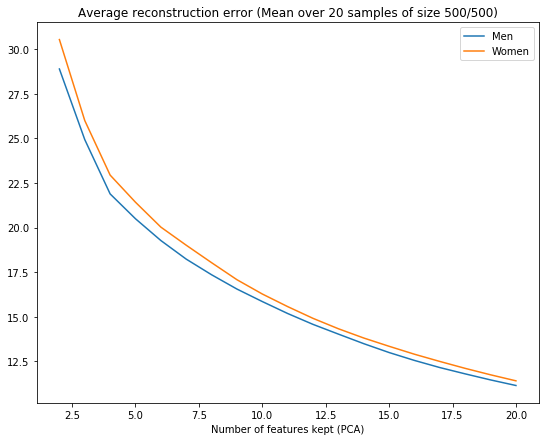

In [23]:
plt.figure(figsize=(9, 7))
plt.plot(dim, np.mean(np.array(list(male_error.values())), axis=0), label="Men")
plt.plot(dim, np.mean(np.array(list(female_error.values())), axis=0), label="Women")
plt.legend()
plt.title("Average reconstruction error (Mean over 20 samples of size 500/500)")
plt.xlabel("Number of features kept (PCA)")
plt.show()

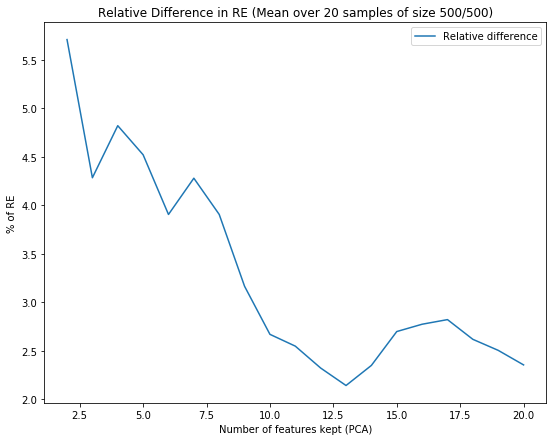

In [24]:
rel_diff = (np.mean(np.array(list(female_error.values())),axis=0)-np.mean(np.array(list(male_error.values())), axis=0))/np.mean(np.array(list(male_error.values())), axis=0)
plt.figure(figsize=(9, 7))
plt.plot(dim, rel_diff*100, label="Relative difference")
plt.legend()
plt.title("Relative Difference in RE (Mean over 20 samples of size 500/500)")
plt.xlabel("Number of features kept (PCA)")
plt.ylabel("% of RE")
plt.show()

By sampling the gap reduces a little but still persists. We can then say that there a difference of the order of 4% in the reconstruction error between men and women. 

We can observe the same on the credit dataset between low education and high education samples (we show it later).

# Introducing Fairness in PCA 

Instead of minimizing the reconstruction error the authors propose the following program : 


$\min _{U \in \mathbb{R}^{m \times n}, \operatorname{rank}(U) \leq d} \max \left\{\frac{1}{|A|} \operatorname{loss}\left(A, U_{A}\right), \frac{1}{|B|} \operatorname{loss}\left(B, U_{B}\right)\right\}
$

where $  loss(Y,Z) := || Y - Z ||_F^2 - || Y - \hat{Y} ||_F^2 $, $\hat{Y}$ being the optimal rank $d$ approximation of $Y$.

To solve this problem, the authors propose an algorithm with two main steps. The first one consists in solving an SDP and the second in solving a linear program. 


First, let us define 3 useful functions. We write below function for computing the loss defined above : **fair_loss**, one to compute the frobenius inner product between two matrices : **frob_innerproduct** and a last one to compute an optimal rank d approximation : **rank_approx**.

In [26]:
def fair_loss(X, proj, d):
    pca = PCA(n_components=d)
    pca.fit(X)
    opt_proj = pca.inverse_transform(pca.transform(X)) 
    return re(X, proj) - re(X, opt_proj)

In [32]:
def frob_innerproduct(a, b):
     """ Frobenius inner product
        -----------
        Parameters :
        a, b : array of same dimensions
        -----------
        Returns : 
        <a,b>_F
    """
    return np.trace(a.T @ b)

In [36]:
def rank_approx(M, d):
    """ Low rank approximation of matrices using SVD decomposition
        -----------
        Parameters :
        M : array 
        d : lower dimension wanted
        -----------
        Returns : 
        L, optimal rank d approximation of M.
    """
    M_U, M_eig, M_V = np.linalg.svd(M)
    L = np.outer(M_U[:, 0], M_V[0, :]) * M_eig[0]
    for j in range(1,d):
        L += np.outer(M_U[:, j], M_V[j, :]) * M_eig[j]
    return L

As explained in the report, the solving of the SDP is done in an approximate manner using a multiplicative weight method. We code the function needed to solve it before giving a code for Fair PCA. 

In [33]:
def oracle(p, alpha, beta, A, B, d):
    """ Oracle fo Fair PCA - Algorithm 2
        -----------
        Parameters :
        p : tuple of size 2 such that each component are positive and sum to 1.
        alpha : float
        beta : float
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        -----------
        Returns : 
        P, z1, z2 such that : 
            
            P, z1, z2 = argmin p1*z1 + p2*z2
            s.t.
                z1 = alpha - 1/m1 <A'A, P>
                z2 = beta - 1/m1 <B'B, P>
                P is a matrix of size nxn such that 0 <= P <= P and Tr(P) <= d.
    """
    
    p1, p2, m1, m2 = p[0], p[1], A.shape[0], B.shape[0]
    mat = p1/m1 * A.T @ A + p2/m2 * B.T @ B
    pca = PCA(n_components=d)
    pca.fit(mat)
    V = pca.inverse_transform(pca.transform(mat))
    #V = pca(mat, d)
    P = V@V.T
    z1 = alpha - (1/m1) * frob_innerproduct(A.T @ A, P)
    z2 = beta - (1/m2) * frob_innerproduct(B.T @ B, P)
    return P, z1, z2

In [34]:
def MW_PCA(alpha, beta, A, B, eta, T, d):
    """ Multiplicative weight update for faire PCA - Algorithm 3
        -----------
        Parameters :
        alpha : float
        beta : float
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        eta : float, must be stricly positive
        T : int, must be positive (According to the reference paper, no need for T to be very large : a fews tens)
        -----------
        Returns : 
        P, z such that : 
            
            P, z = argmin z
            s.t.
                z1 >= alpha - 1/m1 <A'A, P>
                z2 >= beta - 1/m2 <B'B, P>
                P is a matrix of size nxn such that 0 <= P <= P and Tr(P) <= d.
    """
    p = [0.5, 0.5] #initialize values for p for the oracle function
    Ps = []
    m1, m2 = A.shape[0], B.shape[0]
    #Looping T times
    for t in range(1, T+1):
        Pt, m1t, m2t = oracle(p, alpha, beta, A, B, d)
        Ps.append(Pt)
        p_hat1, p_hat2 = p[0] * np.exp(eta*m1), p[1] * np.exp(eta*m2)
        s = p_hat1 + p_hat2
        p = [p_hat1/s, p_hat2/s]
    #return values found
    P = np.mean(Ps, axis=0)
    z = max(alpha - (1/m1) * frob_innerproduct(A.T @ A, P), beta - (1/m2) * frob_innerproduct(B.T @ B, P))
    return P, z

All blocks needed to code a Fair PCA solver are now available. Before writing the function we recall, the way in which we will write the matrices that will define the linear program.

Original program :

$
\begin{array}{l}\underset{z \in\mathbf{R}, \lambda\in\mathbf{R^n}}{\operatorname{min}} z\\  \begin{aligned} \text { s.t. } z & \geq \frac{1}{m_{1}}\left(\|\widehat{A}\|_{F}^{2}-\left\langle A^{\top} A, \sum_{j=1}^{n} \lambda_{j} u_{j} u_{j}^{T}\right\rangle\right)=\frac{1}{m_{1}}\left(\|\widehat{A}\|_{F}^{2}-\sum_{j=1}^{n} \lambda_{j} \cdot\left\langle A^{\top} A, u_{j} u_{j}^{T}\right\rangle\right) \\ z & \geq \frac{1}{m_{2}}\left(\|\widehat{B}\|_{F}^{2}-\left\langle B^{\top} B, \sum_{j=1}^{n} \lambda_{j} u_{j} u_{j}^{T}\right\rangle\right)=\frac{1}{m_{2}}\left(\|\widehat{B}\|_{F}^{2}-\sum_{j=1}^{n} \lambda_{j} \cdot\left\langle B^{\top} B, u_{j} u_{j}^{T}\right\rangle\right) \\ & \sum_{i=1}^{n} \lambda_{i} \leq d \\ & 0 \leq \lambda_{i} \leq 1 \end{aligned}\end{array}
$

Which we want to write under the form : 

$$
\begin{array}{l}\underset{x \in\mathbf{R^{n+1}}}{\operatorname{min}}\mathbf{c}^\intercal \mathbf{x}\\  \begin{aligned} \text { s.t. } Ax & \leq B \end{aligned}\end{array}
$$



As explained in the report 
If we denote: $f_{A_j} = \frac{1}{m_{1}}  \cdot\left\langle A^{\top} A, u_{j} u_{j}^{T}\right\rangle $ and $f_{B_j} = \frac{1}{m_{1}}  \cdot\left\langle B^{\top} B, u_{j} u_{j}^{T}\right\rangle $, we then have:


$\begin{bmatrix}
    {1 & 1 & \cdots & 1 & 0 \\
1 & 0 & \cdots & 0 & 0 \\
0 & 1 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots &  \vdots & \vdots\\
0 & 0 & \cdots & 1 & 0\\
-f_{A_1} & 0 & \cdots & -f_{A_n} & -1\\
-f_{B_1} & 0 & \cdots & -f_{B_n} & -1\\
-1 & 0 & \cdots & 0 & 0\\
0 & -1 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots &  \vdots & \vdots\\
0 & 0 & \cdots & -1 & 0\\}
\end{bmatrix} 
\times \begin{bmatrix}
    \lambda_1     \\
    \vdots \\
    \vdots \\
    \vdots \\
    \vdots \\
    \vdots \\
    \vdots \\


    \lambda_n \\
    z
\end{bmatrix}\leq 
\begin{bmatrix}
    d     \\
    1 \\
    \vdots \\
    1 \\
    \frac{-\|\widehat{A}\|_{F}^{2}}{m_{1}}  \\
    \frac{-\|\widehat{B}\|_{F}^{2}}{m_{2}}  \\
    0 \\


    \vdots \\
    0
\end{bmatrix}
$

In [77]:
def fair_PCA(A, B, d):
    """ Fair PCA - Algorithm 1
        -----------
        Parameters :
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        d : lower dimension wanted
        -----------
        Returns : 
        U of shape (m, n) st m = m1 + m2 and rank(U) <= d+1
    """
    #step 1 
    m1, m2 = A.shape[1], B.shape[1]
    A_hat = rank_approx(A, d)
    B_hat = rank_approx(B, d)
    print("Step 1 done")
    print("-----------")
    #step 2 
    alpha, beta, eta, T = frob_innerproduct(A_hat, A_hat)/m1, frob_innerproduct(B_hat, B_hat)/m2, 1, 20
    P, z = MW_PCA(alpha, beta, A, B, eta, T, d)
    print("Step 2 done")
    print("-----------")
    #step 3 
    P_U, P_eig, P_V = np.linalg.svd(P)
    print("Step 3 done")
    print("-----------")
    #step 4 
    #Here we will solve a LP, we first constuct matrices in order to write the LP problem 
    #in a canonical form as explained earlier (so we can use a library to solve it).
    n = A.shape[1]
    #construct a matrix of constraint : 
    A_lp_const = np.pad(np.eye(n), ((1,2), (0,1)), mode='constant', constant_values=((1,0), (0,0)))
    A_lp_const[n+1, n] = -1
    A_lp_const[n+2, n] = -1
    ata = A.T @ A
    btb = B.T @ B
    for j in range(n):
        uut = np.outer(P_U[:, j], P_V[j, :])
        fAj = -frob_innerproduct(ata, uut)/m1
        fBj = -frob_innerproduct(btb, uut)/m2
        A_lp_const[n+1, j] = fAj
        A_lp_const[n+2, j] = fBj
    A_lp_const = np.concatenate((A_lp_const, np.pad(-np.eye(n), ((0,0), (0,1)), mode='constant', constant_values=((0,0), (0,0)))))
    #now construct vector of values (i.e. b ) and coefficients (i.e. c)
    b = np.ones(n+3)
    b[0] = d 
    b[-1] = -frob_innerproduct(B_hat, B_hat)/m2
    b[-2] = -frob_innerproduct(A_hat, A_hat)/m1
    b = np.concatenate((b, np.zeros(n)))
    c = np.zeros(n+1)
    c[-1] = 1
    print("Starting LP solve...")
    #A,b,c must in the "matrix" library format
    coefs = solvers.lp(matrix(list(c)), matrix(A_lp_const), matrix(list(b)),show_progress=False)
    z_opt = np.array(coefs['x'])[-1]
    lambda_bar = np.array(coefs['x'])[:-1]
    print("Step 4 done")
    print("-----------")
    #Step 5 : construct lambda* and P*
    lambda_bar = 1 - np.sqrt(np.maximum(1-lambda_bar,0))
    #warning
    #if (np.sum(lambda_bar) > d + 2) or (np.sum(lambda_bar) < d - 1):
    P_star = np.outer(P_U[:, 0], P_V[0, :]) * lambda_bar[0]
    for j in range(1, len(lambda_bar)):
        if lambda_bar[j] > 0.07:
            P_star += np.outer(P_U[:, j], P_V[j, :]) * lambda_bar[j]
    print("Step 5 done")
    print("-----------")
    #Finally construct U (pca matrix)
    U = np.concatenate((A, B)) @ P_star
    return U

#### Fair PCA applied to Faces In the Wild data

In [78]:
#to speed computations, we sample 500 men and 500 women
#AND we re center data
A_test = A.sample(500)

B_test = B.sample(500)

M_test = pd.concat([A_test, B_test], axis=0)


In [80]:
%time U = fair_PCA(A_test, B_test, 20)

Step 1 done
-----------
Step 2 done
-----------
Step 3 done
-----------
Starting LP solve...
     pcost       dcost       gap    pres   dres   k/t
 0:  9.1093e+00 -4.1436e+03  2e+04  2e+00  1e+02  1e+00
 1:  3.3037e+00 -6.7108e+02  2e+03  4e-01  2e+01  3e+00
 2:  3.4698e+00 -1.2126e+02  2e+02  7e-02  3e+00  7e-01
 3:  3.2570e+00 -3.3616e+01  5e+01  2e-02  9e-01  1e-01
 4:  3.1706e+00 -2.1071e+01  3e+01  1e-02  6e-01  7e-02
 5:  2.5740e+00 -2.1936e+01  3e+01  1e-02  6e-01  7e-02
 6:  3.0012e+00 -1.4648e+01  2e+01  1e-02  4e-01  3e-02
 7:  2.7689e+00 -1.5003e+01  2e+01  1e-02  4e-01  3e-02
 8:  2.2464e+00 -1.0886e+01  2e+01  8e-03  3e-01  1e-02
 9:  2.3253e+00 -1.0280e+01  2e+01  7e-03  3e-01  1e-02
10:  2.0658e+00 -1.0270e+01  2e+01  7e-03  3e-01  9e-03
11:  1.7330e+00 -8.9534e+00  1e+01  6e-03  3e-01  8e-03
12:  1.6167e+00 -7.9097e+00  1e+01  6e-03  2e-01  6e-03
13:  1.3502e+00 -5.0609e+00  7e+00  4e-03  2e-01  4e-03
14:  1.4715e+00 -4.8326e+00  7e+00  4e-03  2e-01  4e-03
15:  1.3234e+

In [81]:
U.shape #check the shape is correct

(1000, 1764)

In [82]:
np.linalg.matrix_rank(U) #the matrix we got is indeed of rank d = 20 (or d+1)

20

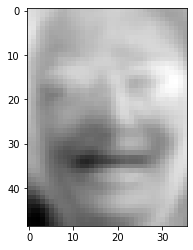

In [37]:
plt.imshow(U[0, :].reshape(shape), cmap='gray') #example of reconstructed image

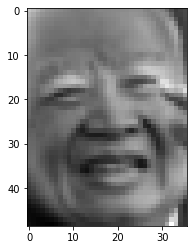

In [38]:
plt.imshow(np.array(A_test)[0, :].reshape(shape), cmap='gray') #original image

In [39]:
print("After fair PCA, RE on Male :", re(A_test, U[:500]), "|| Female : ", re(B_test, U[500:]))

After fair PCA, RE on Male : 11.004076803382791 || Female :  11.333796857167615


In [84]:
%%time
re_fairpca_male = []
re_fairpca_female = []

fairloss_fairpca_male = []
fairloss_fairpca_female = []

dim = [d for d in range(2,21)]
for d in dim:
    U = fair_PCA(A_test, B_test, d)
    #computing RE and fair loss for male with dimensionnality reduction d
    re_fairpca_male.append(re(A_test, U[:500]))
    fairloss_fairpca_male.append(fair_loss(A_test, U[:500], d))
    #computing RE and fair loss for female with dimensionnality reduction d
    re_fairpca_female.append(re(B_test, U[500:]))
    fairloss_fairpca_female.append(fair_loss(B_test, U[500:], d))


Step 1 done
-----------
Step 2 done
-----------
Step 3 done
-----------
Starting LP solve...
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2273e+00 -4.1150e+03  2e+04  3e+00  1e+02  1e+00
 1: -8.1560e-01 -6.6362e+02  2e+03  5e-01  2e+01  3e+00
 2: -3.8778e-01 -3.5413e+01  6e+01  2e-02  9e-01  3e-01
 3: -2.3666e-01 -8.9247e+00  2e+01  6e-03  2e-01  9e-02
 4:  6.2575e-02 -1.0435e+00  2e+00  8e-04  3e-02  8e-03
 5:  6.4805e-02 -1.8085e-01  4e-01  2e-04  6e-03  2e-03
 6:  6.3861e-02  3.0394e-02  6e-02  2e-05  8e-04  7e-05
 7:  6.4609e-02  6.4264e-02  6e-04  2e-07  8e-06  7e-07
 8:  6.4617e-02  6.4613e-02  6e-06  2e-09  8e-08  7e-09
 9:  6.4617e-02  6.4617e-02  6e-08  2e-11  8e-10  7e-11
Optimal solution found.
Step 4 done
-----------
Step 5 done
-----------
Step 1 done
-----------
Step 2 done
-----------
Step 3 done
-----------
Starting LP solve...
     pcost       dcost       gap    pres   dres   k/t
 0:  5.2906e+00 -4.1482e+03  2e+04  3e+00  1e+02  1e+00
 1: -2.7436e-01 -6

In [88]:
re_pca_male = []
re_pca_male = []
fairloss_pca_male = []
fairloss_pca_female = []


dim = [d for d in range(2,21)]
for d in dim:
    #projected = pca(M, d)
    pca = PCA(n_components=d)
    pca.fit(M)
    #computing RE for men with dimensionnality reduction d
    re_pca_male.append(re(A, pca.inverse_transform(pca.transform(A))))
    fairloss_pca_male.append(fair_loss(A, pca.inverse_transform(pca.transform(A)), d))

    #computing RE for women with dimensionnality reduction d
    re_pca_female.append(re(B, pca.inverse_transform(pca.transform(B))))
    fairloss_pca_female.append(fair_loss(B, pca.inverse_transform(pca.transform(B)), d))

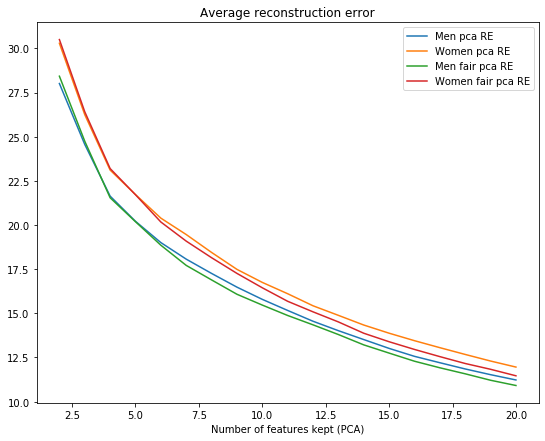

In [91]:
plt.figure(figsize=(9, 7))
plt.plot(dim, re_pca_male, label="Men pca RE")
plt.plot(dim, re_pca_female, label="Women pca RE")
plt.plot(dim, re_fairpca_male, label="Men fair pca RE")
plt.plot(dim, re_fairpca_female, label="Women fair pca RE")
plt.legend()
plt.title("Average reconstruction error")
plt.xlabel("Number of features kept (PCA)")
plt.show()

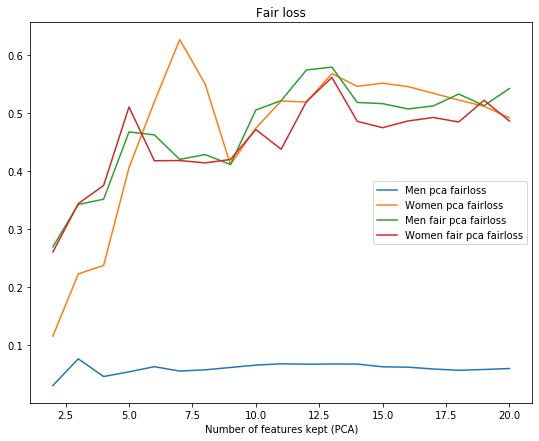

In [92]:
plt.figure(figsize=(9, 7))
plt.plot(dim, fairloss_pca_male, label="Men pca fairloss")
plt.plot(dim, fairloss_pca_female, label="Women pca fairloss")
plt.plot(dim, fairloss_fairpca_male, label="Men fair pca fairloss")
plt.plot(dim, fairloss_fairpca_female, label="Women fair pca fairloss")
plt.legend()
plt.title("Fair loss")
plt.xlabel("Number of features kept (PCA)")
plt.show()

#### Applying Fair PCA on Credit Data

In [46]:
#BIAIS BTW HIGH/LOW EDUCATED
re_pca_low = []
re_pca_high = []
fairloss_pca_low = []
fairloss_pca_high = []


dim = [d for d in range(2,21)]
for d in dim:
    #projected = pca(M, d)
    pca = PCA(n_components=d)
    pca.fit(M_credit)
    #computing RE for men with dimensionnality reduction d
    re_pca_low.append(re(A_credit, pca.inverse_transform(pca.transform(A_credit))))
    fairloss_pca_low.append(fair_loss(A_credit, pca.inverse_transform(pca.transform(A_credit)), d))

    #computing RE for women with dimensionnality reduction d
    re_pca_high.append(re(B_credit, pca.inverse_transform(pca.transform(B_credit))))
    fairloss_pca_high.append(fair_loss(B_credit, pca.inverse_transform(pca.transform(B_credit)), d))

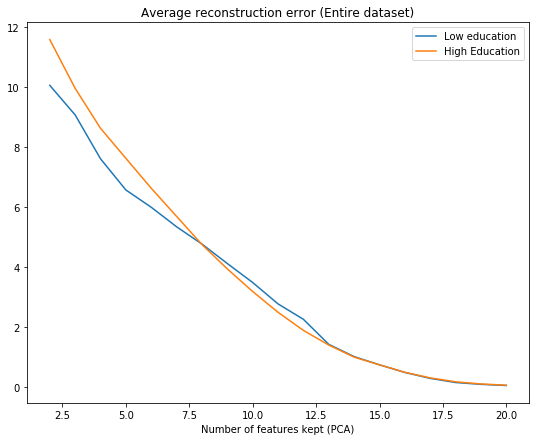

In [28]:
plt.figure(figsize=(9, 7))
plt.plot(dim, re_pca_low, label="Low education")
plt.plot(dim, re_pca_high, label="High Education")
plt.legend()
plt.title("Average reconstruction error (Entire dataset)")
plt.xlabel("Number of features kept (PCA)")
plt.show()

On this dataset, the difference is not in the same direction for all dimension but still we see a difference.

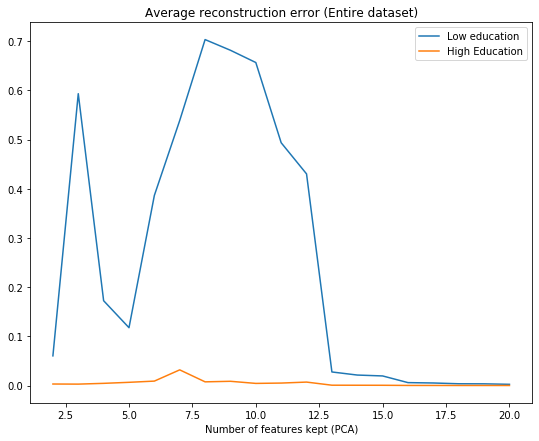

In [29]:
plt.figure(figsize=(9, 7))
plt.plot(dim, fairloss_pca_low, label="Low education")
plt.plot(dim, fairloss_pca_high, label="High Education")
plt.legend()
plt.title("Average reconstruction error (Entire dataset)")
plt.xlabel("Number of features kept (PCA)")
plt.show()

In [59]:
A_test_credit = A_credit.sample(500)
B_test_credit = B_credit.sample(500)
M_test_credit = pd.concat([A_test, B_test], axis=0)

In [65]:
A_test_credit.shape

(500, 22)

In [60]:
%%time
re_fairpca_low = []
re_fairpca_high = []

fairloss_fairpca_low = []
fairloss_fairpca_high = []

dim = [d for d in range(2,21)]
for d in dim:
    U = fair_PCA(A_test_credit, B_test_credit, d)
    #computing RE and fair loss for low educated with dimensionnality reduction d
    re_fairpca_low.append(re(A_test_credit, U[:500]))
    fairloss_fairpca_low.append(fair_loss(A_test_credit, U[:500], d))
    #computing RE and fair loss for high educated with dimensionnality reduction d
    re_fairpca_high.append(re(B_test_credit, U[500:]))
    fairloss_fairpca_high.append(fair_loss(B_test_credit, U[500:], d))


Step 1 done
-----------
Step 2 done
-----------
Step 3 done
-----------
Starting LP solve...
     pcost       dcost       gap    pres   dres   k/t
 0:  5.9417e+01  1.3859e+04  4e+03  4e-02  1e+04  1e+00
 1:  4.7477e+00  1.0649e+03  1e+02  3e-03  8e+02  5e+00
 2:  8.5715e-01  3.1697e+02  4e+01  9e-04  2e+02  2e+00
 3:  1.5635e+00  8.6918e+01  1e+01  3e-04  7e+01  2e-01
 4:  1.7902e+00  1.7603e+01  2e+00  5e-05  1e+01  5e-02
 5:  2.0721e+00  2.4688e+00  5e-02  1e-06  3e-01  1e-03
 6:  2.0806e+00  2.0846e+00  5e-04  1e-08  3e-03  1e-05
 7:  2.0807e+00  2.0807e+00  5e-06  1e-10  3e-05  1e-07
 8:  2.0807e+00  2.0807e+00  5e-08  1e-12  3e-07  1e-09
 9:  2.0807e+00  2.0807e+00  5e-10  1e-14  3e-07  1e-11
10:  2.0807e+00  2.0797e+00  6e-12  5e-16  1e-03  1e-13
11:  2.0807e+00  1.6654e+00  2e-12  6e-17  2e+00  5e-14
12:  2.0807e+00 -1.2244e+01  9e-14  1e-16  2e+01  2e-15
13:  2.0807e+00 -9.9583e+01  5e-14  1e-16  9e+01  1e-15
14:  2.0807e+00 -1.7413e+02  5e-14  7e-17  2e+02  1e-15
15:  2.0807e+

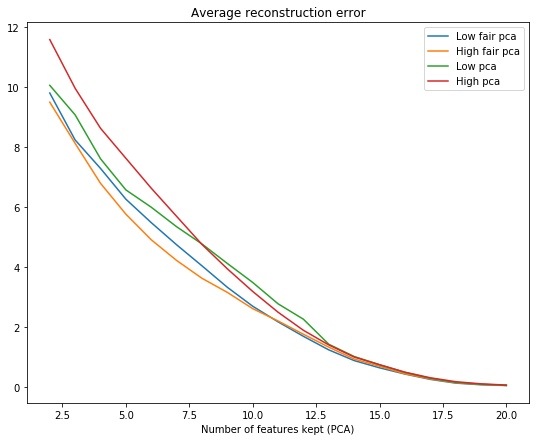

In [62]:
plt.figure(figsize=(9, 7))
plt.plot(dim, re_fairpca_low, label="Low fair pca")
plt.plot(dim, re_fairpca_high, label="High fair pca")
plt.plot(dim, re_pca_low, label="Low pca")
plt.plot(dim, re_pca_high, label="High pca")
plt.legend()
plt.title("Average reconstruction error")
plt.xlabel("Number of features kept (PCA)")
plt.show()

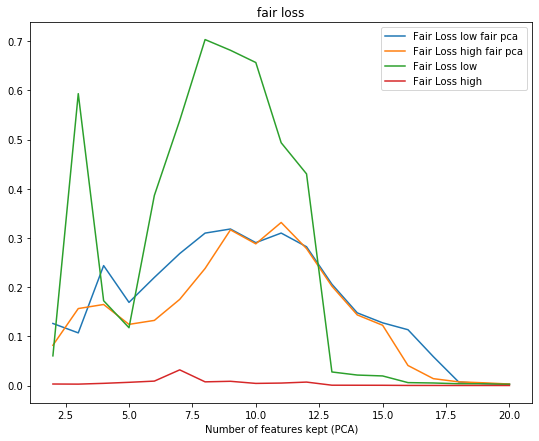

In [64]:
plt.figure(figsize=(9, 7))
plt.plot(dim, fairloss_fairpca_low, label="Fair Loss low fair pca")
plt.plot(dim, fairloss_fairpca_high, label="Fair Loss high fair pca")
plt.plot(dim, fairloss_pca_low, label="Fair Loss low")
plt.plot(dim, fairloss_pca_high, label="Fair Loss high")
plt.legend()
plt.title("fair loss")
plt.xlabel("Number of features kept (PCA)")
plt.show()

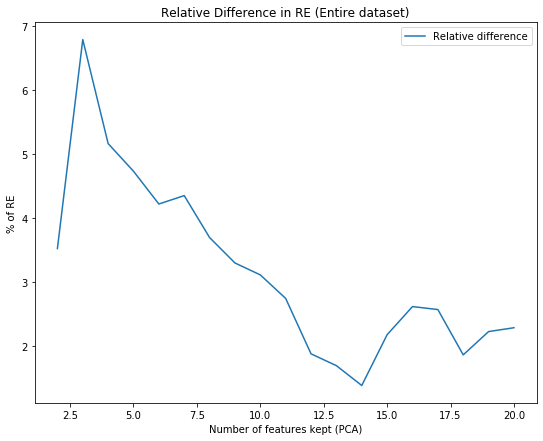

In [48]:
rel_diff = (np.array(re_female)-np.array(re_male))/np.array(re_male)
plt.figure(figsize=(9, 7))
plt.plot(dim, rel_diff*100, label="Relative difference")
plt.legend()
plt.title("Relative Difference in RE (Entire dataset)")
plt.xlabel("Number of features kept (PCA)")
plt.ylabel("% of RE")
plt.show()